First, we install a package that will allow us to upsample our dataset, and load the libraries we will need for our data analysis.

In [1]:
#CAUTION: Takes a long time to load.
install.packages("themis")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
#load libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)
library(RColorBrewer)
options(repr.matrix.max.rows = 10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Next, we read in our data. Upon inspection, we see that the percanetage of observations corresponding to real pulsars is around 9%. To balance the proportion of real pulsar observations to false pulsar observations, we upsample the dataset (i.e. create more real pulsar observations that have predictor values similar to those in the original dataset). We also scale and center our 6 predictor values as part of preprocessing the data.

In [3]:
#Add columns
unscaled_data <- read_csv("pulsar_data.csv", 
                        col_names = c("mean_integrated_profile", 
                                      "stand_dev_integrated_profile", 
                                      "exc_kurtosis_integrated_profile", 
                                      "skew_integrated_profile",
                                      "mean_dmsnr", 
                                      "stand_dev_dmsnr", 
                                      "exc_kurtosis_dmsnr", 
                                      "skew_dmsnr", "class")) 

unscaled_data <- unscaled_data |>
    mutate(class = as_factor(class))
#unscaled_data 

#Class proportions in pulsar dataset (Imbalanced)
num_obs <- nrow(unscaled_data)
pulsar_proportions <- unscaled_data |>
    group_by(class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(unscaled_data))
pulsar_proportions

#Scale data and Upsample to balance data
pulsar_recipe <- recipe(class ~ exc_kurtosis_integrated_profile + skew_dmsnr + stand_dev_integrated_profile + 
                        mean_dmsnr + skew_integrated_profile + exc_kurtosis_dmsnr, data = unscaled_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(class, over_ratio = 1, skip = FALSE) |>
    prep()

standardized_pulsar <- bake(pulsar_recipe, unscaled_data)
standardized_pulsar

#check proportions of upsampled data
new_pulsar_proportions <- standardized_pulsar |>
    group_by(class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(standardized_pulsar))
new_pulsar_proportions

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): mean_integrated_profile, stand_dev_integrated_profile, exc_kurtosis...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


class,n,percent
<fct>,<int>,<dbl>
0,16259,90.842552
1,1639,9.157448


exc_kurtosis_integrated_profile,skew_dmsnr,stand_dev_integrated_profile,mean_dmsnr,skew_integrated_profile,exc_kurtosis_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.66955083,-0.2874301,1.3347944,-0.3194313,-0.4004478,-0.07279575,0
-0.01178443,0.2115755,1.8022150,-0.3710915,-0.3705251,0.50441285,0
-0.14522850,-0.3913625,-1.0532928,-0.3220980,-0.1165896,-0.12599257,0
-0.51339427,-0.4812869,1.5532110,-0.3043957,-0.3901672,-0.31225666,0
0.11560548,1.3867553,-0.8588548,-0.3879995,-0.1048632,1.32398915,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
4.5937270,-0.9951917,-1.94839076,3.663225484,4.5763657,-1.8597015,1
1.5433045,-0.9135816,-1.42107989,0.168035397,1.1068852,-1.2023643,1
2.2214407,-0.8437052,0.01297727,0.012118668,0.9829160,-0.9994977,1


class,n,percent
<fct>,<int>,<dbl>
0,16259,50
1,16259,50


Here, we split our preproceesed data into training and testing sets, and put 75% of the data into the training set. We also build our recipe given our chosen predictors. 

In [4]:
set.seed(1)
pulsar_split <- initial_split(standardized_pulsar, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split) 

pulsar_recipe <- recipe(class ~ exc_kurtosis_integrated_profile + skew_dmsnr + stand_dev_integrated_profile + 
                        mean_dmsnr + skew_integrated_profile + exc_kurtosis_dmsnr, data = pulsar_train)
pulsar_recipe

#pulsar_prediction_accuracy <- pulsar_test_predictions |>
  #  metrics(truth = class, estimate = .pred_class) |>
 #   filter(.metric == "accuracy")
#pulsar_prediction_accuracy

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          6

Now we perform cross validation on the training set in order to select the best K value for our classifier (number of neighbors). To do this, we use 10 folds. But first, we build a classification model that specifies that we want to tune the number of neighbors. We create a tibble that contains each K value that we want to test.

In [5]:
#build the model, CAUTION: Takes a long time to load.
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

#Create a tibble for the K values
k_vals <- tibble(neighbors = seq(from = 1, to = 75, by = 3))
#k_vals

#Set up and perform 10 fold cross validation
pulsar_vfold <- vfold_cv(pulsar_train, v = 10, strata = class)

knn_results <- workflow() |>
               add_recipe(pulsar_recipe) |>
               add_model(knn_spec) |>
               tune_grid(resamples = pulsar_vfold, grid = k_vals) |>
               collect_metrics() #assess the accuracy 
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9899135,10,0.0006231595,Preprocessor1_Model01
1,roc_auc,binary,0.9899135,10,0.0006231595,Preprocessor1_Model01
4,accuracy,binary,0.9818358,10,0.0009016456,Preprocessor1_Model02
4,roc_auc,binary,0.9904933,10,0.0006373877,Preprocessor1_Model02
7,accuracy,binary,0.9683867,10,0.0010628963,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
67,roc_auc,binary,0.9815655,10,0.0006499470,Preprocessor1_Model23
70,accuracy,binary,0.9413239,10,0.0014903287,Preprocessor1_Model24
70,roc_auc,binary,0.9813138,10,0.0006630973,Preprocessor1_Model24


To determine the best K to use, we filter the collected metrics from cross validation and plot the accuracy against the K values we tested.

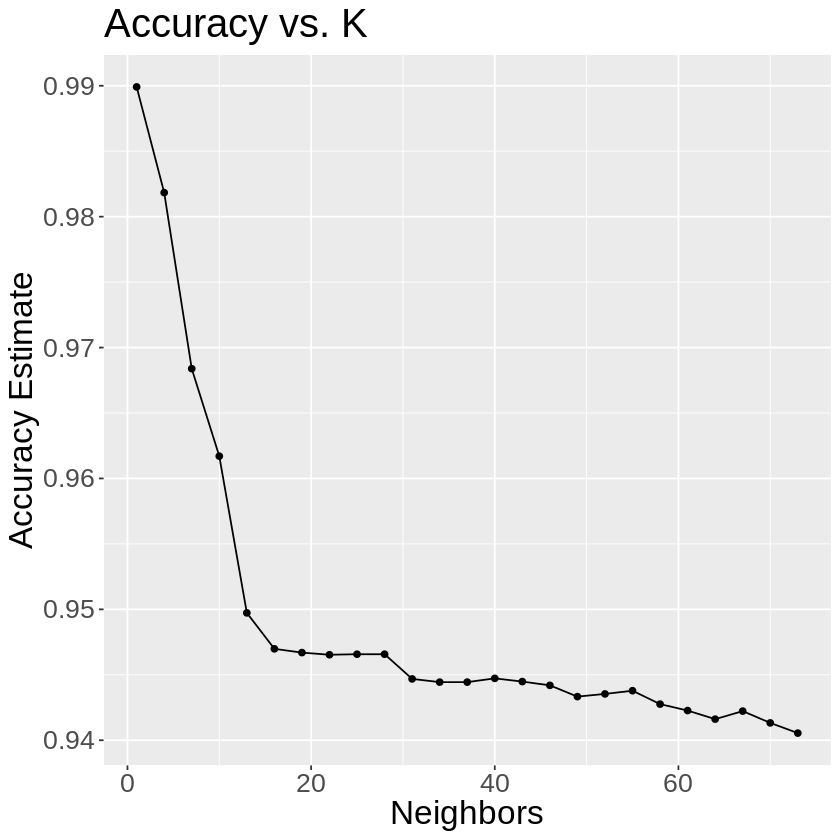

In [6]:
accuracies <- knn_results |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Accuracy vs. K") +
       theme(text = element_text(size = 20))
accuracy_versus_k

Based on the above plot, we see that the accuracy decreases quite steeply as the number of neighbors increases, before leveling off from around K = 16 onwards. We choose K = 17 for our classification model because the accuracy is high at this point, and the accuracy does not change drastically when looking at similar K values. Overall, we want to avoid overfitting the data by selecting too few neighbors, and 17 is an odd number (given that K-nearest neighbors classifies observations based on a majority rules system, using an even number of neighbors could be problematic in the event of a tie, since our class variable is binary). 

Upon determining the optimal K value for our classifier, we can finally predict on our testing set. As done below, we use the same recipe as before, but a new model that sets the number of neighbors to 17 must be built. Once we have used the model to predict the classes of the observations in the test set, we take a confusion matrix to view the accuracy.

In [10]:
knn_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
                    set_engine("kknn") |>
                    set_mode("classification")

pulsar_fit_final <- workflow() |>
        add_recipe(pulsar_recipe) |>
        add_model(knn_spec_final) |>
        fit(data = pulsar_train)

pulsar_test_predictions_final <-  predict(pulsar_fit_final, pulsar_test) |>
        bind_cols(pulsar_test)

pulsar_test_predictions_final                

confusion_final <- pulsar_test_predictions_final |>
    conf_mat(truth = class, estimate = .pred_class)
confusion_final

.pred_class,exc_kurtosis_integrated_profile,skew_dmsnr,stand_dev_integrated_profile,mean_dmsnr,skew_integrated_profile,exc_kurtosis_dmsnr,class
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,-0.66955083,-0.2874301,1.3347944,-0.3194313,-0.4004478,-0.07279575,0
0,-0.01178443,0.2115755,1.8022150,-0.3710915,-0.3705251,0.50441285,0
0,-0.75014651,-0.6292692,-0.1843379,-0.2455865,-0.2409772,-0.49428426,0
0,-0.52527844,0.8513931,-0.3640536,-0.3726235,-0.2683108,0.81412244,0
0,-0.31974505,1.1132819,0.3606682,-0.3768221,-0.3286328,1.12389396,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,1.690154,-0.9396332,0.3868629,0.4015984,0.49902994,-1.3179713,1
1,0.601641,-0.9132343,-0.3099150,0.2196956,0.02837944,-1.1944020,1
1,4.593727,-0.9951917,-1.9483908,3.6632255,4.57636570,-1.8597015,1


          Truth
Prediction    0    1
         0 3838  212
         1  227 3853

To visualize the accuracy of our classification model, we create a new column in the predictions table that will allow us to visualze the test data in such a way that colour-coding the observations will let us see the information stored in the confusion matrix. (***not worded very well)

In [18]:
mutated_predictions <- pulsar_test_predictions_final |>
    mutate(new_cat = case_when(.pred_class == 0 & class == 0 ~ "False pulsar, correctly classified",
                               .pred_class == 1 & class == 1 ~ "Real pulsar, correctly classified",
                               .pred_class == 1 & class == 0 ~ "False pulsar, incorrectly classified",
                               .pred_class == 0 & class == 1 ~ "Real pulsar, incorrectly classified"))
mutated_predictions

#this code came from: https://community.rstudio.com/t/creating-a-new-variable-under-conditions-of-other-two-variables/51825 

.pred_class,exc_kurtosis_integrated_profile,skew_dmsnr,stand_dev_integrated_profile,mean_dmsnr,skew_integrated_profile,exc_kurtosis_dmsnr,class,new_cat
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
0,-0.66955083,-0.2874301,1.3347944,-0.3194313,-0.4004478,-0.07279575,0,"False pulsar, correctly classified"
0,-0.01178443,0.2115755,1.8022150,-0.3710915,-0.3705251,0.50441285,0,"False pulsar, correctly classified"
0,-0.75014651,-0.6292692,-0.1843379,-0.2455865,-0.2409772,-0.49428426,0,"False pulsar, correctly classified"
0,-0.52527844,0.8513931,-0.3640536,-0.3726235,-0.2683108,0.81412244,0,"False pulsar, correctly classified"
0,-0.31974505,1.1132819,0.3606682,-0.3768221,-0.3286328,1.12389396,0,"False pulsar, correctly classified"
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,1.690154,-0.9396332,0.3868629,0.4015984,0.49902994,-1.3179713,1,"Real pulsar, correctly classified"
1,0.601641,-0.9132343,-0.3099150,0.2196956,0.02837944,-1.1944020,1,"Real pulsar, correctly classified"
1,4.593727,-0.9951917,-1.9483908,3.6632255,4.57636570,-1.8597015,1,"Real pulsar, correctly classified"


Visualization of our classifier's accuracy:

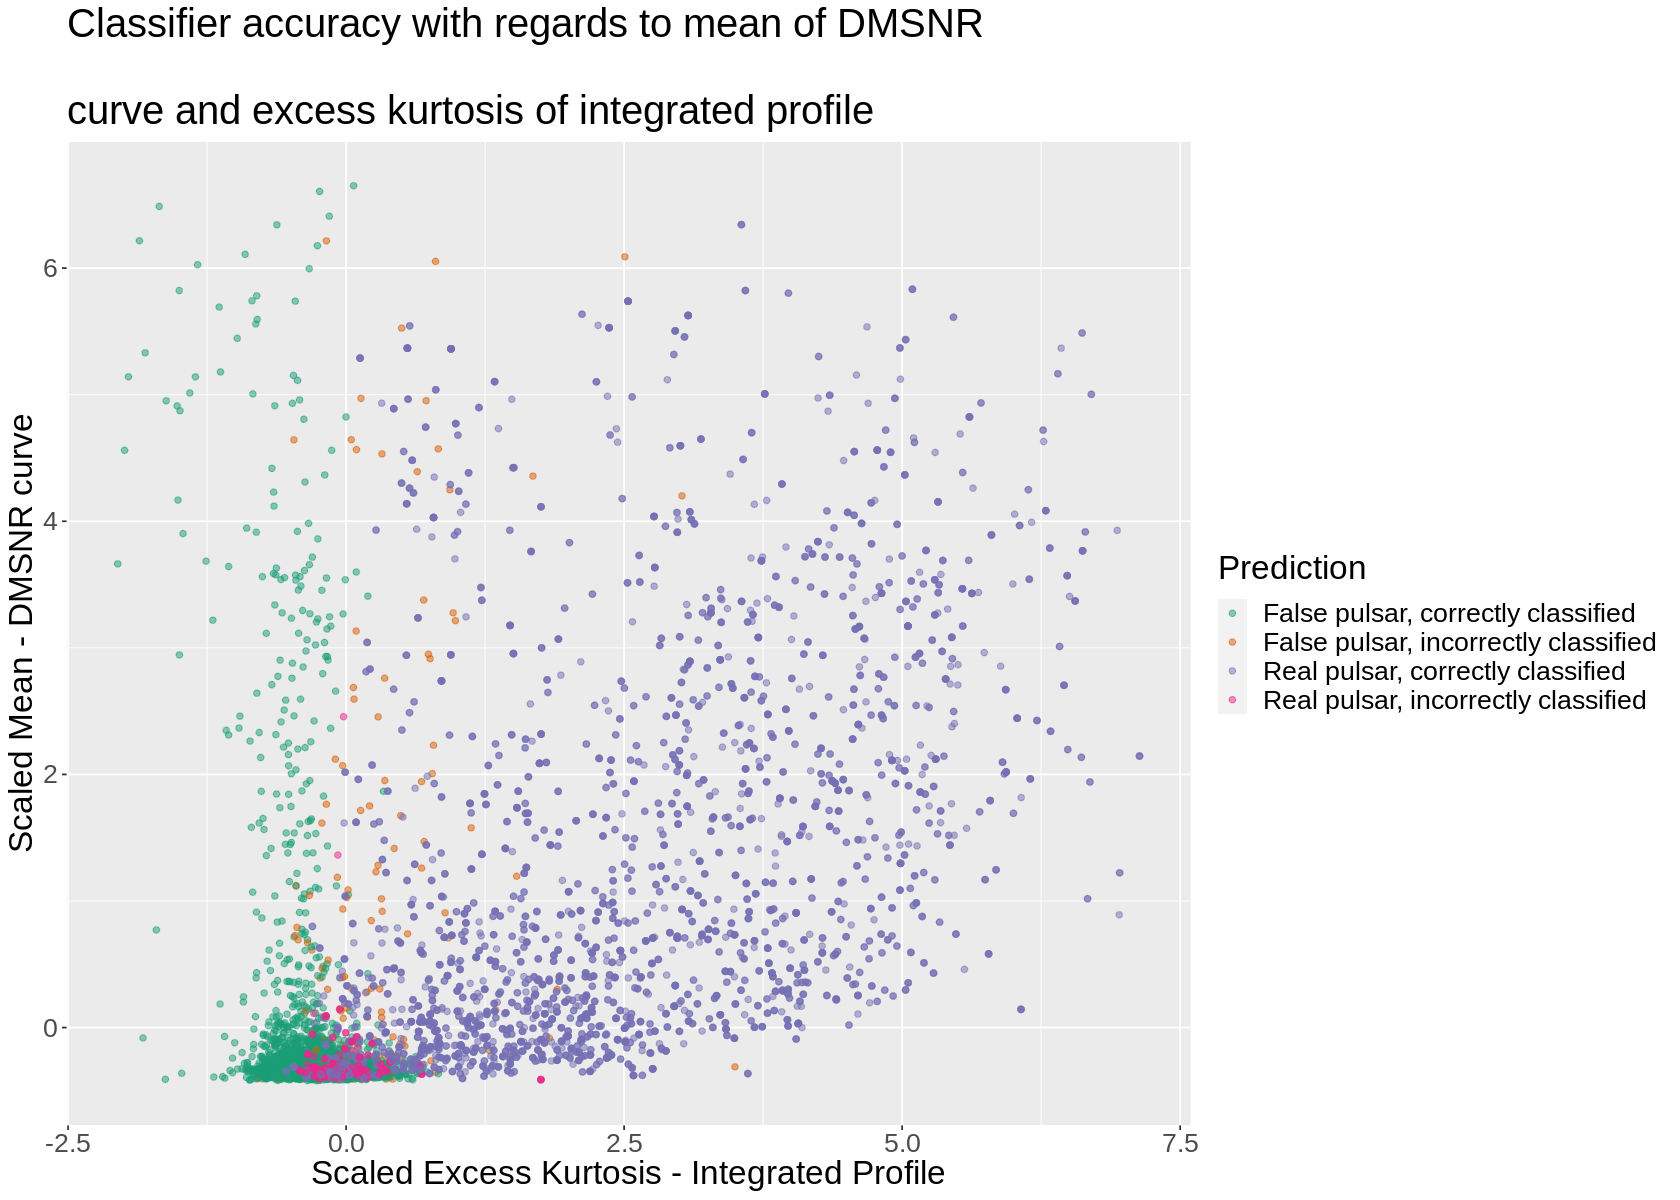

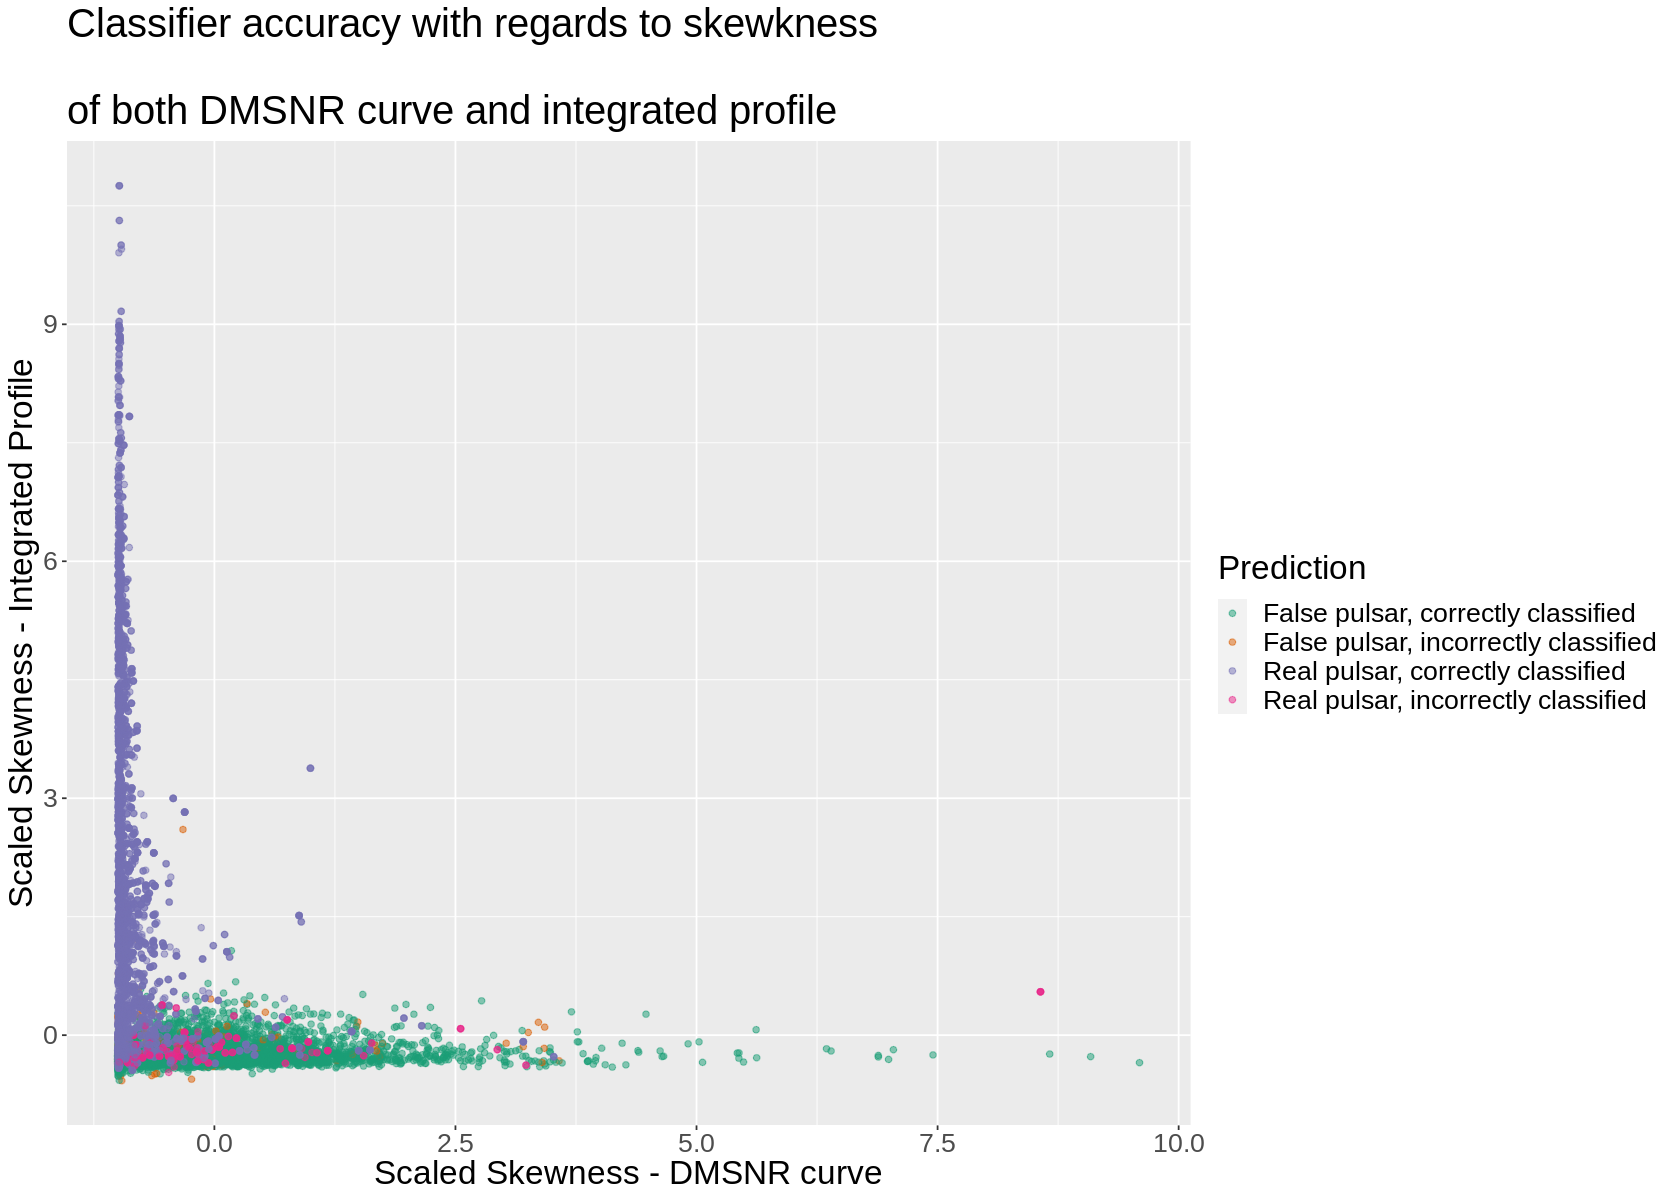

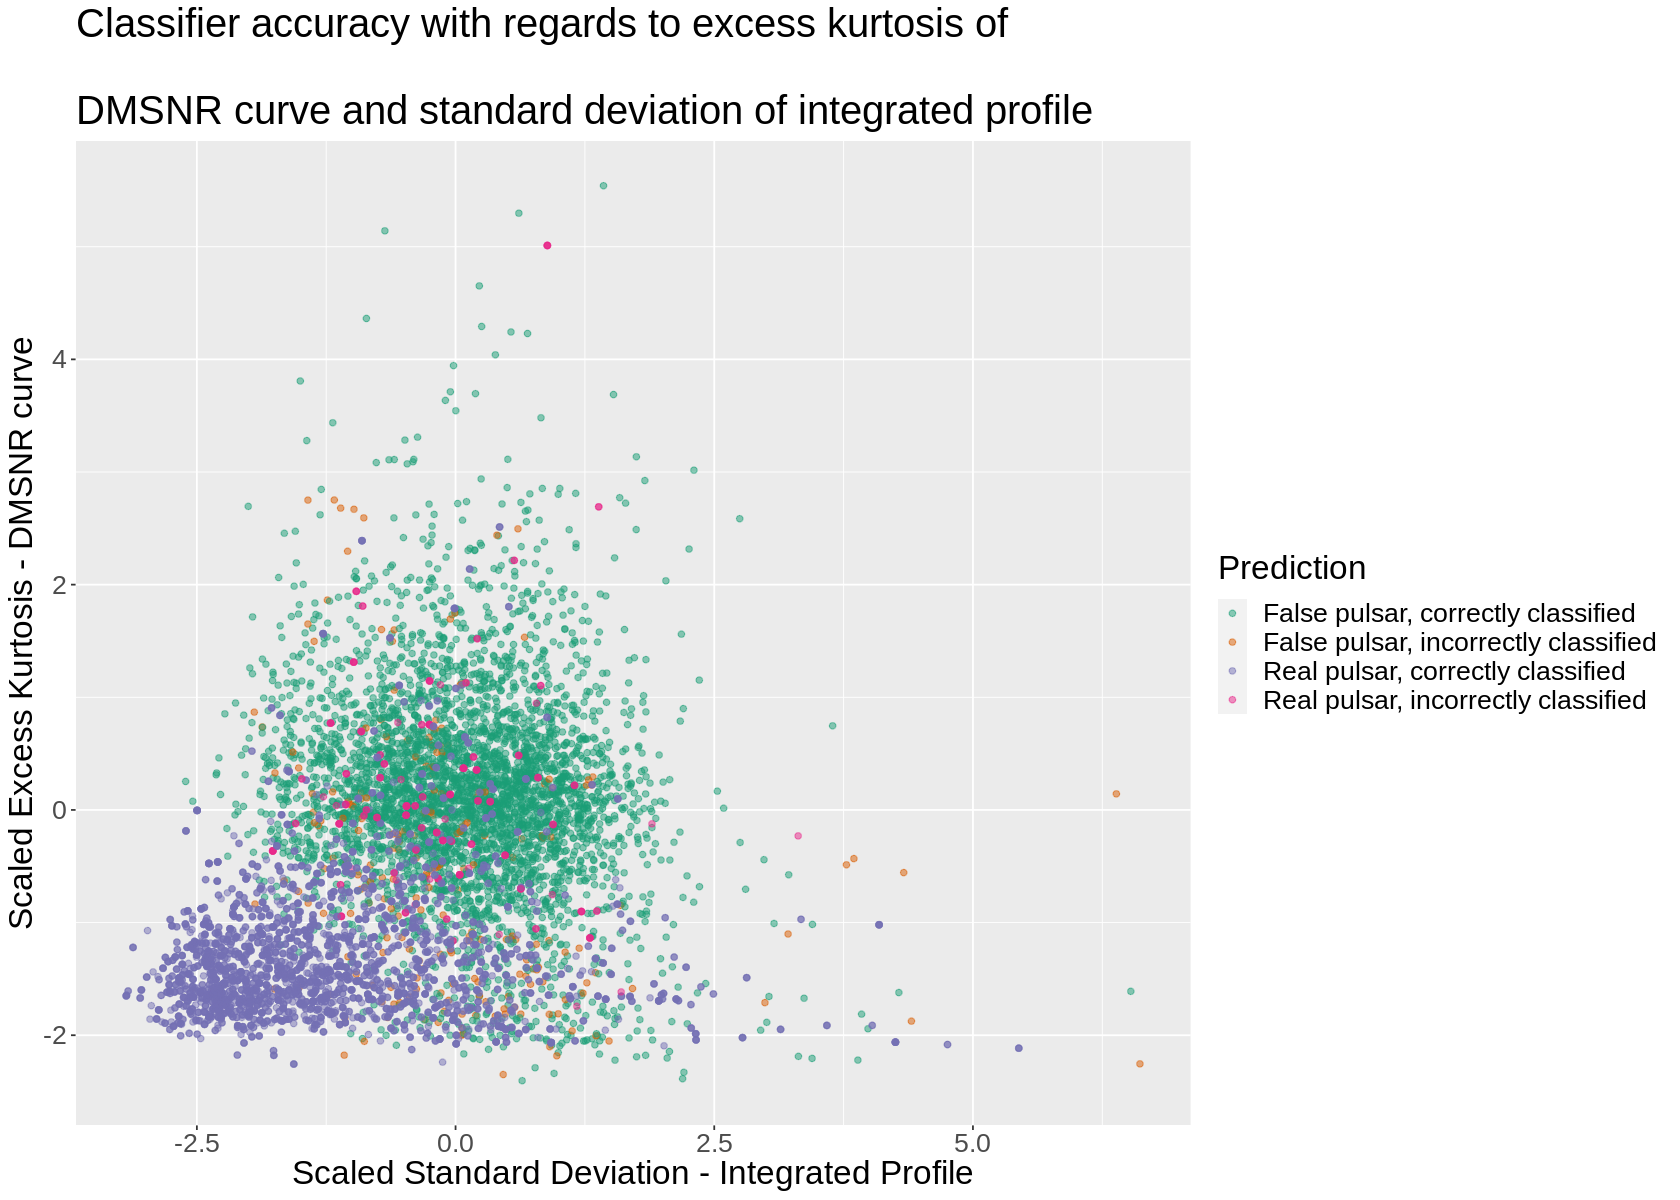

In [23]:
options(repr.plot.height = 10, repr.plot.width = 14)

#First 2 predictors
plot_1 <- ggplot() +
    geom_point(data = mutated_predictions, mapping = aes(x = exc_kurtosis_integrated_profile, 
                                                              y = mean_dmsnr, colour = new_cat), alpha = 0.5) +
    labs(x = "Scaled Excess Kurtosis - Integrated Profile", y = "Scaled Mean - DMSNR curve", colour = "Prediction") +
    ggtitle("Classifier accuracy with regards to mean of DMSNR
                \ncurve and excess kurtosis of integrated profile") +
    scale_color_brewer(palette = "Dark2") +
    theme(text = element_text(size = 20))
plot_1



#Next 2 predictors
plot_2 <- ggplot() +
    geom_point(data = mutated_predictions, mapping = aes(x = skew_dmsnr,
                                                              y = skew_integrated_profile, colour = new_cat), alpha = 0.5) +
    labs(x = "Scaled Skewness - DMSNR curve", y = "Scaled Skewness - Integrated Profile", colour = "Prediction") +
    ggtitle("Classifier accuracy with regards to skewkness
                \nof both DMSNR curve and integrated profile") +
    scale_color_brewer(palette = "Dark2") +
    theme(text = element_text(size = 20))
plot_2



#Last 2 predictors
plot_3 <- ggplot() +
    geom_point(data = mutated_predictions, mapping = aes(x = stand_dev_integrated_profile, 
                                                             y = exc_kurtosis_dmsnr, colour = new_cat), alpha = 0.5) +
    labs(x = "Scaled Standard Deviation - Integrated Profile", y = "Scaled Excess Kurtosis - DMSNR curve", colour = "Prediction") +
    ggtitle("Classifier accuracy with regards to excess kurtosis of
                \nDMSNR curve and standard deviation of integrated profile") +
    scale_color_brewer(palette = "Dark2") +
    theme(text = element_text(size = 20))
plot_3

As can be seen above, there are very few observations in the testing set that were incorrectly classified. This indicates that our model is quite accurate. We can represent the accuracy of our model as a percentage, as well:

In [24]:
#From the confusion matrix:

accuracy_perc <- ((3838 + 3853)/8130)*100
accuracy_perc

[1] 94.60025

Therefore, <b> ~95% </b> is a good estimate of how accuracte our classication model is.